In [1]:
#@title [RUN] Import modules
import numpy as np
import seaborn as sns
import math
import itertools
import scipy as sp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import Planetoid, ZINC, GNNBenchmarkDataset
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

import pdb

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

from mycolorpy import colorlist as mcp
import matplotlib.cm as cm

from typing import Mapping, Tuple, Sequence, List
import colorama

import scipy.linalg
from scipy.linalg import block_diag

In [2]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Ti


In [3]:
# @title [RUN] Helper functions for plots and visualisations

####### VISUALISATIONS #######

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                    special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                    crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                               nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
    """
    This function is a basic, non-bijective one for visualising the embedings.
    Please use it for guidance, not as a mathematical proof in Part 3.
    It is used just for educational/visualisation purpose.
    You are free to change it with whatever suits you best.
    Hash the tensor representing nodes' features
    to a number in [0,1] used to represent a color

    Args:
      node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
    Returns:
      list of num_graphs arrays in [0,1], each of dim (num_nodes)
    """
    chunk_size_graph = [x.shape[0] for x in node_emb]
    start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

    node_emb_flatten = np.concatenate(node_emb).mean(-1)

    min_emb = node_emb_flatten.min()
    max_emb = node_emb_flatten.max()
    node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb++0.00001)

    #split in graphs again according to (start_idx_graph, chunk_size_graph)
    node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
    return node_emb_hashed

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))


In [4]:
train_zinc_dataset = ZINC(root='', split='train', subset=True)
val_zinc_dataset = ZINC(root='', split='val', subset=True)
test_zinc_dataset = ZINC(root='', split='test', subset=True)

print(f"\nTrain examples: {len(train_zinc_dataset)}")
print(f"Val examples: {len(val_zinc_dataset)}")
print(f"Test examples: {len(test_zinc_dataset)}\n")

one_graph = train_zinc_dataset[0]

print(f"First graph contains {one_graph.x.shape[0]} nodes, each characterised by {one_graph.x.shape[1]} features")
print(f"Graph labels have shape: {one_graph.y.shape}")



Train examples: 10000
Val examples: 1000
Test examples: 1000

First graph contains 29 nodes, each characterised by 1 features
Graph labels have shape: torch.Size([1])


In [5]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure
            for a mini-batch it will store a big (sparse) graph
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index,
                                       # we work with a binary adj containing 1 if an edge exist
                                       torch.ones((self.edge_index.shape[1])),
                                       torch.Size((self.num_nodes, self.num_nodes))
                                       )

In [6]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)
    node_offset = graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):

        # concat the features
        batch_x = torch.concat( [batch_x, graph.x] )
        # concat the labels
        batch_y = torch.concat( [batch_y, graph.y] )

        # concat the adjacency matrix as a block diagonal matrix
        batch_edge_index = torch.concat( [batch_edge_index,
                                          graph.edge_index + node_offset], dim=1 )
        # create the array of indexes mapping nodes in the batch-graph to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)
        batch_batch = torch.concat( [batch_batch,
                                     torch.tensor([ (idx+1) for xi in range(0,graph.num_nodes)]) ] )

        # update the node offset
        node_offset = node_offset + graph.num_nodes

        #create the big sparse graph
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

In [7]:


batch_zinc = create_mini_batch(train_zinc_dataset[:3])

In [8]:
class GINLayer(nn.Module):
    """A single GIN layer, implementing MLP(AX + (1+eps)X)"""
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int, eps: float=0.0):
        super(GINLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        # ============ YOUR CODE HERE =============
        # epsilon should be a learnable parameter
        self.eps = torch.nn.Parameter(torch.Tensor([eps]), requires_grad=True)
        #self.eps = torch.nn.Parameter(torch.ones(1)), requires_grad=True)
        # =========================================
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, self.out_feats)
        self.activation = nn.ReLU()

    def forward(self, x, adj_sparse):
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GIN: (AX + (1+eps)X)
        x = adj_sparse @ x + (1+self.eps) * x
        # project the features (MLP_k)
        x = self.linear1(x)
        x = self.activation(x) # F.relu(x)
        out = self.linear2(x)

        # =========================================
        return out

In [9]:
from torch.nn.modules.linear import Linear
class SimpleGIN(nn.Module):
    """
    A Graph Neural Network containing GIN layers
    as in https://arxiv.org/abs/1810.00826
    The readout function used to obtain graph-lvl representations
    is just the sum of the nodes in the graph

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim,
                 num_layers=2, eps=0.0, molecular=True):
        super(SimpleGIN, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # instead of nn.Linear as in SimpleMLP model,
        # now we have (num_layers) GINLayer(s), each with different parameters
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers-1)]
        self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        for i in range(self.num_layers-1):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
        x = self.layers[-1](x, adj_sparse)

        # ============ YOUR CODE HERE =============
        # graph-level representations are obtain by pooling info from the nodes using sum
        #y_hat = scatter_sum(graph.x, graph.batch, dim=0)
        y_hat = scatter_sum(x, graph.batch, dim=0)
        # =========================================

        y_hat = y_hat.squeeze(-1)
        #return also the final node embeddings (for visualisations)
        return y_hat, x

In [10]:
def train(dataset, model, optimiser, epoch, loss_fct, metric_fct, print_every):
    """ Train model for one epoch
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()
        y_hat, _ = model(batch)
        loss = loss_fct(y_hat, batch.y)
        metric = metric_fct(y_hat, batch.y)
        loss.backward()
        optimiser.step()
        if (i+1) % print_every == 0:
            print(f"Epoch {epoch} Iter {i}/{num_iter}",
                  f"Loss train {loss.data}; Metric train {metric.data}")
    return loss, metric

def evaluate(dataset, model, loss_fct, metrics_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = int(len(dataset)/BATCH_SIZE)
    metrics_eval = 0
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        y_hat, _ = model(batch)
        metrics = metrics_fct(y_hat, batch.y)
        loss = loss_fct(y_hat, batch.y)
        metrics_eval += metrics.data
        loss_eval += loss.data
    metrics_eval /= num_iter
    loss_eval /= num_iter
    return loss_eval, metrics_eval

def train_eval(model, train_dataset, val_dataset, test_dataset,
               loss_fct, metric_fct, print_every=1):
    """ Train the model for NUM_EPOCHS epochs
    """
    #Instantiatie our optimiser
    optimiser = optim.Adam(model.parameters(), lr=LR)
    training_stats = None

    #initial evaluation (before training)
    val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    train_loss, train_metric = evaluate(train_dataset[:BATCH_SIZE], model,
                                        loss_fct, metric_fct)
    epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss,
                   'train_metric': train_metric, 'val_metric': val_metric,
                   'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    for epoch in range(NUM_EPOCHS):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss, train_metric = train(train_dataset, model, optimiser, epoch,
                                         loss_fct, metric_fct, print_every)
        val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
        print(f"[Epoch {epoch+1}]",
              f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
              f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss.detach().numpy(), 'val_loss': val_loss.detach().numpy(),
                       'train_metric': train_metric.detach().numpy(), 'val_metric': val_metric.detach().numpy(),
                       'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss, test_metric = evaluate(test_dataset, model,  loss_fct, metric_fct)
    print(f"Test metric: {test_metric:.3f}")
    return training_stats

In [11]:

class GIN(nn.Module):
    """
    A Graph Neural Network containing GIN layers
    as in https://arxiv.org/abs/1810.00826
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dim,
                 num_layers=2,
                 eps=0.0,
                 molecular=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = Linear(input_dim, hidden_dim)

        # ============ YOUR CODE HERE =============
        # parameter list for each layer
        self.params = [torch.nn.Parameter(torch.Tensor([eps]), requires_grad=True) for i in range(num_layers)]

        # should be the same as before (an nn.ModuleList of GINLayers)
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers)] # all layers are this
        #self.layers += [GINLayer(hidden_dim, output_dim, hidden_dim, eps)]
        self.layers = nn.ModuleList(self.layers)

        # layer to compute prediction from the concatenated intermediate representations
        self.pred_layers = GINLayer(hidden_dim, output_dim, hidden_dim, eps)
        # =========================================

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)
        # ============ YOUR CODE HERE =============
        # perform the forward pass with the new readout function
        xs = []
        for i in range(self.num_layers):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
            #print('i: '+str(i))
            #print(x.shape)
            xs.append(self.params[i] * x)

        xconcat = torch.stack(xs, dim=1).sum(dim=1)
        #print('xconcat')
        #print(xconcat.shape)

        x2 = self.pred_layers(xconcat, adj_sparse) # get it to (xs[0].shape[0], 1)
        y_hat = scatter_sum(x2, graph.batch, dim=0)
        y_hat = y_hat.squeeze(-1)
        # =========================================
        # return also the final node embeddings (for visualisations)
        return y_hat, x

[Epoch 1] train loss: 0.885 val loss: 1.759 train metric: 0.885 val metric: 1.759
[Epoch 2] train loss: 0.711 val loss: 1.564 train metric: 0.711 val metric: 1.564
[Epoch 3] train loss: 0.636 val loss: 1.510 train metric: 0.636 val metric: 1.510
[Epoch 4] train loss: 0.627 val loss: 1.489 train metric: 0.627 val metric: 1.489
[Epoch 5] train loss: 0.594 val loss: 1.462 train metric: 0.594 val metric: 1.462
[Epoch 6] train loss: 0.603 val loss: 1.438 train metric: 0.603 val metric: 1.438
[Epoch 7] train loss: 0.698 val loss: 1.499 train metric: 0.698 val metric: 1.499
[Epoch 8] train loss: 0.654 val loss: 1.467 train metric: 0.654 val metric: 1.467
[Epoch 9] train loss: 0.679 val loss: 1.479 train metric: 0.679 val metric: 1.479
[Epoch 10] train loss: 0.651 val loss: 1.449 train metric: 0.651 val metric: 1.449
[Epoch 11] train loss: 0.604 val loss: 1.398 train metric: 0.604 val metric: 1.398
[Epoch 12] train loss: 0.626 val loss: 1.396 train metric: 0.626 val metric: 1.396
[Epoch 13] tr

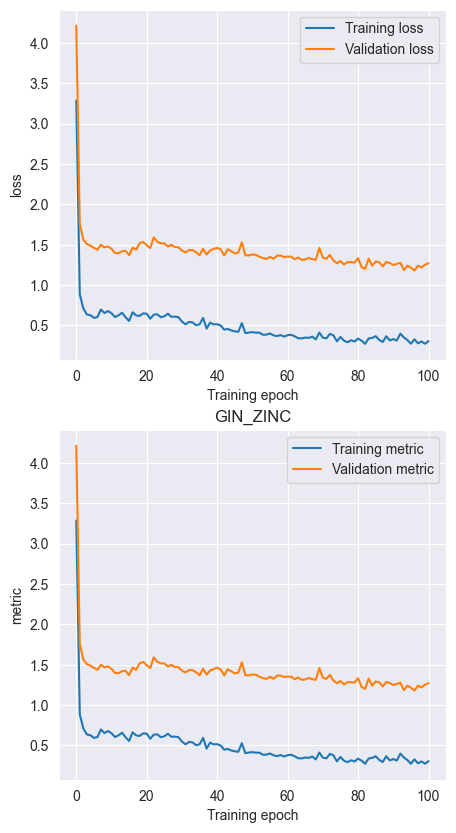

In [12]:
# @title [RUN] Hyperparameters GIN

BATCH_SIZE = 128 #@param {type:"integer"}
NUM_EPOCHS = 100#@param {type:"integer"}
HIDDEN_DIM =  64#@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

# init the model
model_gin = GIN(input_dim=batch_zinc.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4, eps=0.1)

#Train GIN model:
train_stats_gin_zinc = train_eval(model_gin, train_zinc_dataset, val_zinc_dataset,
                                  test_zinc_dataset, loss_fct=F.mse_loss,
                                  metric_fct=F.mse_loss, print_every=150)

plot_stats(train_stats_gin_zinc, name='GIN_ZINC', figsize=(5, 10))